In [26]:
import nltk
import pandas as pd
import json
import gc
import re
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import datetime, timedelta
from nltk.corpus import stopwords

In [14]:
with open("D://Project2017/Product review/pd_reviews.json",encoding='utf8') as json_file:
    jsonVariable = json.load(json_file)

    
review_raw = pd.DataFrame(jsonVariable)
review = review_raw[['variation_asin','country','content','review_id','rating','review_date']]
review = review.rename(columns = {'variation_asin':'asin'})
review['review_date'] = review['review_date'].apply(pd.Series)
review['review_date'] = pd.to_datetime(review['review_date'])

print('All review :', review.shape[0])
start_date = '2016-08-01'

review = review[review['review_date']<start_date]


print('review before 2016/08/01: ',review.shape[0])

All review : 73663
review before 2016/08/01:  51388


In [15]:
###  B012UNOCJY  >>>> SW2700PT,  country  ='com'
###  B012AQIOL8  >>>  UP2716

all_text = review[(review['asin'] == 'B012UNOCJY') & (review['country'] == 'com')]
star_mapping_tb = all_text[['review_id','rating']]
all_text = all_text[['asin','review_id','content','rating','review_date']]

print('Total length = ', all_text.shape[0])
all_text.tail(10)


review_pos = all_text[all_text['rating']>3]
review_neg = all_text[all_text['rating']<=3]


print('Positive length = ', review_pos.shape[0])
print('Negative length = ', review_neg.shape[0])



Total length =  29
Positive length =  26
Negative length =  3


'I’ll admit I’d never heard of the BenQ brand but I don’t get out much so I asked the friendly neighbor guru about it. He said he knew nothing about the monitors but they had been around a while with projectors and components. I hope this monitor wasn’t a mistake.<br/><br/>It is important that you put the box on its side, top side facing up, and slide all of the foam packing out at once when you un-pack the monitor. The components are packed in three stacked layers of foam.<br/><br/>The top layer of foam has the hood. I don’t have a problem with ambient light so I decided not to use it. If you do, be sure to turn the non-reflective side in toward the screen.  The middle layer has the cords, stand, Osd unit and quick-start pamphlet<br/><br/>From here on it depends on your OS and whether you’re connecting to a new computer or one that has already been hooked to another monitor. There is no guarantee this will work with win 10, which is fine with me. Don’t have it, don’t want it. It works

In [48]:
remove_list = ['monitor','benq']

                                
def reg_exp(s_input):

    s_input = re.sub('\.\-',',',s_input)
    s_input = re.sub(r'(<br/>)=+(<br/>)','. ',s_input)
    s_input = re.sub(r'<br/><br/>','. ',s_input)
    s_input = re.sub(r'<br/>','. ',s_input)
    s_input = re.sub('\.{2,3}','. ',s_input)
    s_input = re.sub(r':',': ',s_input)
    s_input = re.sub(r'\"','',s_input)
    s_input = re.sub(r'(“|”)','',s_input)
    s_input = re.sub(r'\’','\'',s_input)
    
    #s_input = re.sub("(?<=[A-Za-z])[\.](?=[A-Za-z])", ". ", s_input)
    s_input = re.sub('\.\s+','. ',s_input)
    return s_input


#### Remove Noun Phrases with 'monitor' and unigram ####
def filter_words(list_all):
    result = [keywords for keywords in list_all if ('monitor' not in keywords) and (len(keywords.split(' '))>=2)]
    return result



def common_word_graph(df_wordset,remove_list,n):
    all_words = []

    for l in df_wordset:
        all_words = all_words+list(l)

    
    all_words = [word for word in all_words if word not in remove_list]
    freqwords = nltk.FreqDist(all_words)

    freqwords.plot(n,cumulative=False)

    
def common_word(df_wordset,remove_list,n):
    all_words = []
  
    for l in df_wordset:
        all_words = all_words+list(l)


    all_words = [word for word in all_words if word not in remove_list]
    freqwords = nltk.FreqDist(all_words)
    
    return freqwords.most_common()    
    
    
def extract_unigram_noun(text):
    stops = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    unigram_list = []
    unigrams_tag = nltk.pos_tag(nltk.word_tokenize(text.lower()))
    for u in unigrams_tag:
        if(u[1][0] == 'N'):
            unigram_list.append(u[0])
    
    unigrams = [lemmatizer.lemmatize(u) for u in unigram_list  if (u not in stops and u.isalnum())]
    
    return set(unigrams)
    



def extract_bigram(text):
    
    tokenized_words = nltk.word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    
    #lemma_words = [lemmatizer.lemmatize(u) for u in tokenized_words]
    
    # Filter out words that have punctuation and make everything lower-case
    stops = set(stopwords.words('english'))
    
    
    bigrams = [b for b in nltk.bigrams(tokenized_words) if (b[0] not in stops and b[1] not in stops) 
               and (b[0].isalnum() and b[1].isalnum()) and (b[0] not in remove_list and b[1] not in remove_list)
               and (not b[0].isdigit() and not b[1].isdigit())]
    
    
    
    bigram_lemma_list = []
    for i in bigrams:

        b1 = lemmatizer.lemmatize(i[0])
        b2 = lemmatizer.lemmatize(i[1])
        bigram_tuple = (b1,b2)
        bigram_lemma_list.append(bigram_tuple)
    
    bigram_list = []
    for i in bigram_lemma_list:

        bigram_string = ' '.join(i)
        bigram_list.append(bigram_string)
        
        
 



    

        
    
    return set(bigram_list)
   

    
def word_Lemmatizer(PatternWord):
    lemma_list = []

    for pattern in PatternWord:
        lemmatizer = WordNetLemmatizer()
        #word_list = pattern.split(' ')
        #sub_list = []
        for word in pattern.split(' '):
            lemma = lemmatizer.lemmatize(word)
       
            #sub_list.append(lemma)
        #sub_list = ' '.join(sub_list)
            lemma_list.append(lemma)
        
    return lemma_list   



In [49]:
review_pos['content'] = review_pos['content'].apply(reg_exp)
unigram_pos = review_pos['content'].apply(extract_unigram_noun)

review_neg['content'] = review_neg['content'].apply(reg_exp)
unigram_neg = review_neg['content'].apply(extract_unigram_noun)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


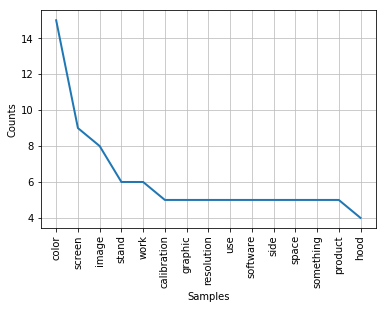

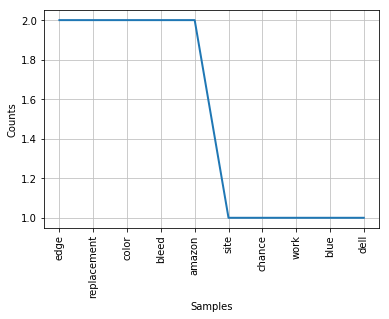

61810    {site, chance, work, blue, dell, gradient, gra...
61811            {picture, jumping, monitor, one, support}
61835    {repair, amazon, edge, rendition, monitor, rep...
Name: content, dtype: object

In [50]:
common_word_graph(unigram_pos,remove_list,15)
unigram_pos

common_word_graph(unigram_neg,remove_list,10)
unigram_neg

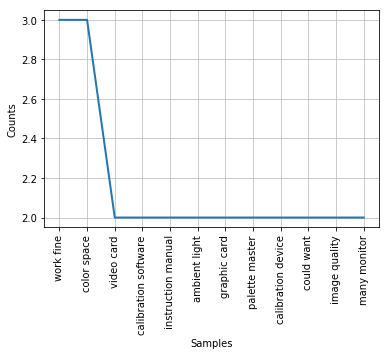

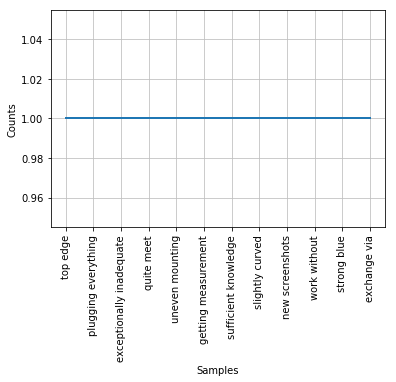

In [51]:
bigram_pos = review_pos['content'].apply(extract_bigram)
#bigram_pos  =bigram_pos.apply(word_Lemmatizer)
common_word_graph(bigram_pos,remove_list,12)

bigram_neg = review_neg['content'].apply(extract_bigram)
#bigram_pos  =bigram_pos.apply(word_Lemmatizer)
common_word_graph(bigram_neg,remove_list,12)

In [52]:


lemmatizer = WordNetLemmatizer()    

b = [('screens','screenshoots'),('monitors','test')]
bigram_lemma_list = []
for i in b:
    print(i[0])
    b1 = lemmatizer.lemmatize(i[0])
    b2 = lemmatizer.lemmatize(i[1])
    bigram_tuple = (b1,b2)
    bigram_lemma_list.append(bigram_tuple)


    

screens
monitors


In [53]:
bigram_lemma_list

[('screen', 'screenshoots'), ('monitor', 'test')]

In [231]:
def bigram_type_convert(bigram_tuple_list)

    bigram_list = []
    for i in bigram_tuple_list:

        bigram_string = ' '.join(i)
        bigram_list.append(bigram_string)
        
        


SyntaxError: invalid syntax (<ipython-input-231-7b867b2e56be>, line 1)

AttributeError: 'Series' object has no attribute 'colname'

In [138]:
review_pos['content'].iloc[0]

"I'll admit I'd never heard of the BenQ brand but I don't get out much so I asked the friendly neighbor guru about it. He said he knew nothing about the monitors but they had been around a while with projectors and components. I hope this monitor wasn't a mistake. It is important that you put the box on its side, top side facing up, and slide all of the foam packing out at once when you un-pack the monitor. The components are packed in three stacked layers of foam. The top layer of foam has the hood. I don't have a problem with ambient light so I decided not to use it. If you do, be sure to turn the non-reflective side in toward the screen. The middle layer has the cords, stand, Osd unit and quick-start pamphlet. From here on it depends on your OS and whether you're connecting to a new computer or one that has already been hooked to another monitor. There is no guarantee this will work with win 10, which is fine with me. Don't have it, don't want it. It works fine with win7 ultra. It w

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'needn',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 'should',
 'shouldn',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 